In [35]:
import pandas as pd
import numpy as np
import time
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as rng
import re
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

caminho_do_projeto = r'C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao'

if caminho_do_projeto not in sys.path:
    sys.path.insert(0, caminho_do_projeto)
from projeto_aplicado.modelos.otimizador_pli import OtimizadorPLI
from projeto_aplicado.modelos.otimizador_aco import OtimizadorACO
from projeto_aplicado.modelos.otimizador_ag import OtimizadorAG
from projeto_aplicado.modelos.otimizador_base import Otimizador
from projeto_aplicado.modelos.analisador import AnalisadorDeSolucao
base = r"C:\\Users\\kmenezes\\OneDrive - unb.br\\tcc_organizacao\\dados"
grafs_dir = r"C:\\Users\\kmenezes\\OneDrive - unb.br\\tcc_organizacao\\graficos"

# Configurações de visualização
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 100)

cor1 = "#006064"
cor2 = "#D35400"
cores = ['#006064', '#D35400', '#2E86C1', '#884EA0', '#28B463', '#7F8C8D']
gradiente = LinearSegmentedColormap.from_list("meu_gradiente", ["#E0F7FA", "#006064"])

In [6]:
#dados lhs
lhs_global = pd.read_csv('novo_lhs_simulacoes.csv')

In [10]:
df = pd.DataFrame()
for arq in os.listdir('resultados_batches_v2/'):
    if 'resultados' in arq:
        result = pd.read_csv(f'resultados_batches_v2/{arq}')
        df = pd.concat([df, result], ignore_index=True)

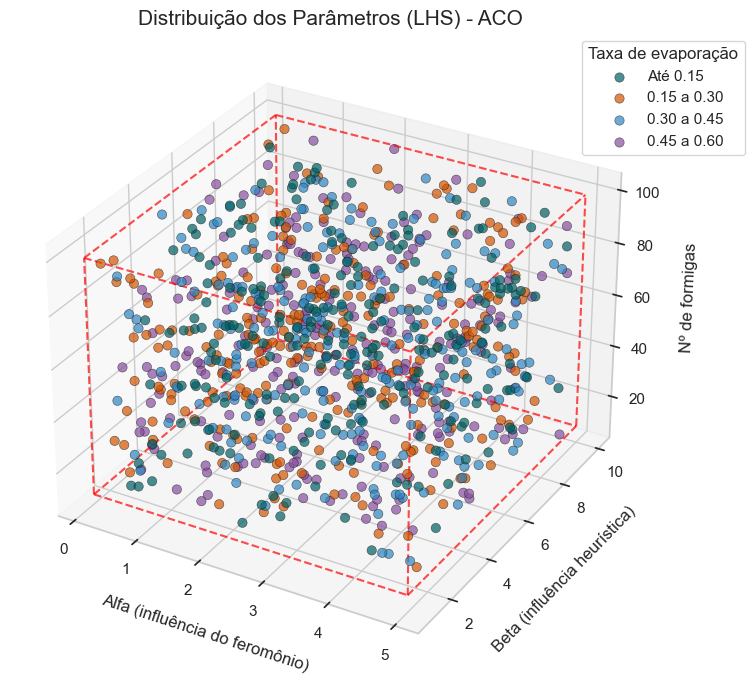

In [ ]:
 #lhs aco

# 1. Carregue seu arquivo LHS
# Substitua pelo caminho correto do seu arquivo
df = lhs_global.copy()

bins = [0.0, 0.15, 0.3, 0.45, .6]
labels = ["Até 0.15", "0.15 a 0.30", "0.30 a 0.45", "0.45 a 0.60"]
df["evap_cat"] = pd.cut(df["taxa_evaporacao"], bins=bins, labels=labels, include_lowest=True)
palette = {
    "Até 0.15":cores[0], "0.15 a 0.30":cores[1], "0.30 a 0.45":cores[2], "0.45 a 0.60":cores[3]
}
# 2. Configura a figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 3. Escolha as 3 colunas que você quer visualizar
# Exemplo com parâmetros do ACO (ajuste os nomes conforme seu CSV)
x_col = 'alfa'
y_col = 'beta'
z_col = 'n_formigas'

xs = df[x_col]
ys = df[y_col]
zs = df[z_col]

# 4. Cria o Scatter Plot
# c=zs colore os pontos baseados na altura Z para facilitar a percepção de profundidade
for cat in df["evap_cat"].cat.categories:
    mask = df["evap_cat"] == cat
    ax.scatter(xs[mask], ys[mask], zs[mask],
                c=palette[str(cat)],
               label=str(cat),
               marker='o', alpha=0.7, s=45, edgecolors='k', linewidth=0.4)


# 5. Desenhar as Linhas Delimitadoras (A Caixa do Espaço de Busca)
# Defina os limites (use min/max dos dados ou seus limites teóricos do LHS)
x_lims = [xs.min(), xs.max()]
y_lims = [ys.min(), ys.max()]
z_lims = [zs.min(), zs.max()]

# Gera todos os 8 cantos do cubo (produto cartesiano dos limites)
corners = list(product(x_lims, y_lims, z_lims))

# Percorre todos os pares de cantos e desenha linha se eles diferirem em apenas 1 dimensão
for p1, p2 in combinations(corners, 2):
    # Calcula a diferença absoluta entre os pontos
    diff = np.abs(np.array(p1) - np.array(p2))
    # Se a diferença for zero em 2 eixos e não-zero no 3º, é uma aresta do cubo
    if np.sum(diff > 0) == 1:
        ax.plot3D([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 
                  color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Labels e Títulos
ax.set_xlabel("Alfa (influência do feromônio)", fontsize=12, labelpad=10)
ax.set_ylabel("Beta (influência heurística)", fontsize=12, labelpad=10)
ax.set_zlabel("Nº de formigas", fontsize=12, labelpad=12)


# Labels
ax.set_title('Distribuição dos Parâmetros (LHS) - ACO', fontsize=15)
leg = ax.legend(title="Taxa de evaporação", bbox_to_anchor=(1.02, 1), loc="upper center", frameon=True)
plt.tight_layout()
#plt.savefig('lhs_distribuicao_clean.png', transparent=True, dpi=300)
plt.savefig('../graficos/aco_lhs_distribuicao_3d.pdf', dpi=300)
plt.show()

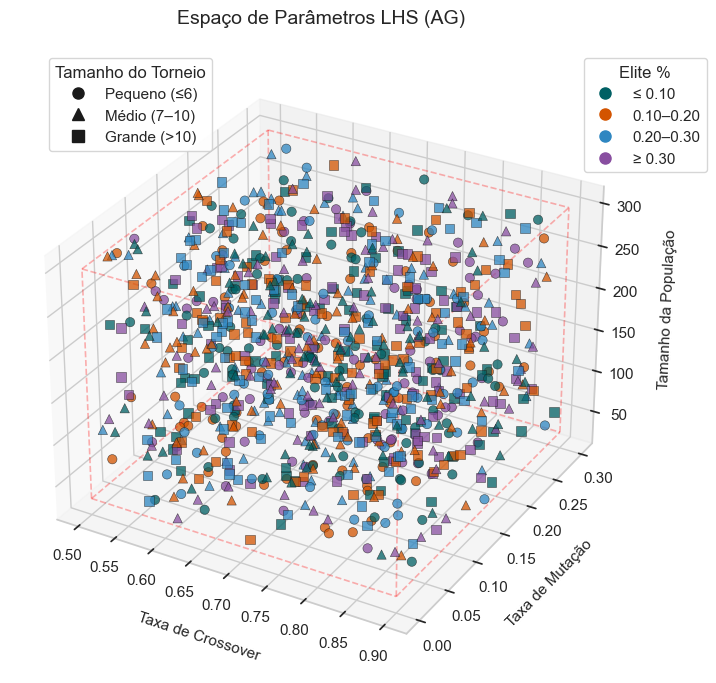

In [ ]:
#Lhs ag
df_ag = lhs_global.copy()
bins_elite = [0.0, 0.1, 0.2, 0.3, 1.0] 
labels_elite = ["≤ 0.10", "0.10–0.20", "0.20–0.30", "≥ 0.30"]

df_ag["elite_cat"] = pd.cut(df_ag["elit_pct"], bins=bins_elite, labels=labels_elite, include_lowest=True)

palette_elite = {
    "≤ 0.10": cores[0],
    "0.10–0.20": cores[1],
    "0.20–0.30": cores[2],
    "≥ 0.30": cores[3],
}

# Grupos para tamanho_torneio (Símbolos)
def grupo_torneio(v):
    if v <= 6: return "Pequeno (≤6)"
    if v <= 10: return "Médio (7–10)"
    return "Grande (>10)"

df_ag["torneio_grupo"] = df_ag["tamanho_torneio"].apply(grupo_torneio)

markers_torneio = {
    "Pequeno (≤6)": "o",   # Círculo
    "Médio (7–10)": "^",   # Triângulo
    "Grande (>10)": "s",   # Quadrado
}

# --- 2. Plotagem ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Plot por grupo e categoria
for grp in df_ag["torneio_grupo"].unique():
    mk = markers_torneio[grp]
    sub = df_ag[df_ag["torneio_grupo"] == grp]
    for cat in df_ag["elite_cat"].cat.categories:
        mask = sub["elite_cat"] == cat
        if mask.sum() == 0:
            continue
        ax.scatter(sub.loc[mask, x_col],
                   sub.loc[mask, y_col],
                   sub.loc[mask, z_col],
                   c=palette_elite[str(cat)],
                   marker=mk,
                   alpha=0.75,
                   s=45,
                   edgecolors='k',
                   linewidth=0.4)

# --- 3. Caixa Delimitadora (Wireframe Box) ---
xs, ys, zs = df_ag[x_col], df_ag[y_col], df_ag[z_col]
x_lims = [xs.min(), xs.max()]
y_lims = [ys.min(), ys.max()]
z_lims = [zs.min(), zs.max()]

corners = list(product(x_lims, y_lims, z_lims))
for p1, p2 in combinations(corners, 2):
    # Conecta apenas pontos que variam em uma única dimensão (arestas do cubo)
    if np.sum(np.abs(np.array(p1) - np.array(p2)) > 0) == 1:
        ax.plot3D(
            [p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
            color='red', linestyle='--', linewidth=1.2, alpha=0.3
        )

# --- 4. Configuração das Legendas Separadas (O PULO DO GATO) ---

# Legenda 1: Formatos (Tamanho do Torneio)
marker_handles = [
    plt.Line2D([], [], color='k', marker=m, linestyle='None', markersize=8, label=g)
    for g, m in markers_torneio.items()
]
first_legend = ax.legend(
    handles=marker_handles, 
    title="Tamanho do Torneio", 
    loc="upper left", 
    bbox_to_anchor=(0.05, 1.0),
    frameon=True
)

# IMPORTANTE: Adicione a primeira legenda manualmente ao artista do eixo
# Isso impede que ela seja apagada quando criarmos a segunda legenda
ax.add_artist(first_legend)

# Legenda 2: Cores (Faixas de Elite)
color_handles = [
    plt.Line2D([], [], color=c, marker='o', linestyle='None', markersize=8, label=l)
    for l, c in palette_elite.items()
]
# Esta segunda chamada cria a legenda padrão (que sobrescreveria a primeira se não tivéssemos salvo)
ax.legend(
    handles=color_handles, 
    title="Elite %", 
    loc="upper left", 
    bbox_to_anchor=(0.91, 1),
    frameon=True
)

# --- 5. Rótulos e Ajustes Finais ---
ax.set_xlabel("Taxa de Crossover", fontsize=11, labelpad=10)
ax.set_ylabel("Taxa de Mutação", fontsize=11, labelpad=10)
ax.set_zlabel("Tamanho da População", fontsize=11, labelpad=10)
ax.set_title("Espaço de Parâmetros LHS (AG)", fontsize=14, pad=20)


plt.tight_layout()
plt.savefig('../graficos/ag_lhs_distribuicao_3d.pdf', dpi=300)
plt.show()

In [4]:
conv = pd.read_csv('estudo_convergencia.csv')
conv = pd.read_csv('resultados_batches_v2/metricas_iteracao.csv')

In [30]:
#Dataframe com as perturbações
df.sort_values('simulacao', inplace=True)
pert = pd.concat([df[['simulacao', 'tempo_perturbacao', 'folga_total']], df['metricas_horario'].apply(eval).apply(pd.Series)], axis=1)#.sort_values('simulacao')
pert = pd.concat([pert, df['metricas_preferencia'].apply(eval).apply(pd.Series)], axis=1)

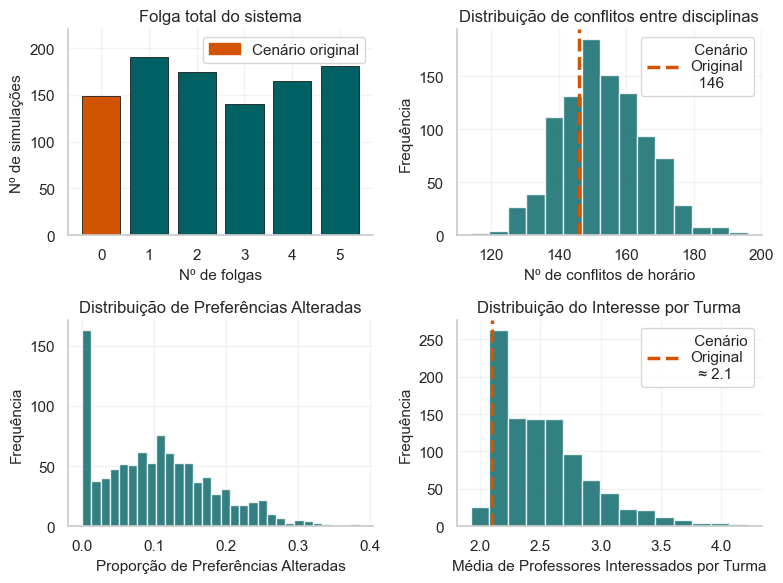

In [103]:
# Grid 2x2: Barras (folga_total), Hist n_conflitos, Hist n_mudancas_horarios, Hist n_interessados_por_turma
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
(ax_bar, ax_conf), (ax_mud, ax_int) = axes

# Paleta principal
cor_bar = cor1
cor_destaque = cor2
cor_hist = cor1
cor_hist2 = cor1

# 1) Barras: folga_total por simulação, destacando a barra da simulação 0 (dados reais)
# Se sua simulação real é a linha com 'simulacao == 0'
d1 = pd.DataFrame(pert['folga_total'].value_counts()).reset_index().sort_values('folga_total')
is_real = (d1['folga_total'] == 0)
cores_barras = np.where(is_real, cor_destaque, cor_bar)

ax_bar.bar(d1['folga_total'].astype(int), d1['count'].astype(int), color=cores_barras, edgecolor='k', linewidth=0.6)
ax_bar.set_title('Folga total do sistema', fontsize=12)
ax_bar.set_xlabel('Nº de folgas', fontsize=11)
ax_bar.set_ylabel('Nº de simulações', fontsize=11)
ax_bar.set_ylim(0, 220)
ax_bar.set_xticks(d1['folga_total'].astype(int))

# Legenda discreta

ax_bar.legend(handles=[
    Patch(color=cor_destaque, label='Cenário original')
], frameon=True)

# 2) Histograma n_conflitos com linha pontilhada em 146 (cenário real)
ax_conf.hist(pert['n_conflitos'], bins=15, color=cor_hist, edgecolor='white', alpha=0.8)
ax_conf.axvline(146, color=cor2, linestyle='--', linewidth=2.5, label=' Cenário\nOriginal\n  146')
ax_conf.set_title('Distribuição de conflitos entre disciplinas', fontsize=12)
ax_conf.set_xlabel('Nº de conflitos de horário', fontsize=11)
ax_conf.set_ylabel('Frequência', fontsize=11)
ax_conf.legend(frameon=True)

# 3) Histograma n_mudancas_horarios
ax_mud.hist(pert['proporcao_perturbacao'], bins=30, color=cor1, edgecolor='white', alpha=0.8)
ax_mud.set_title('Distribuição de Preferências Alteradas', fontsize=12)
ax_mud.set_xlabel('Proporção de Preferências Alteradas', fontsize=11)
ax_mud.set_ylabel('Frequência', fontsize=11)

# 4) Histograma n_interessados_por_turma com linha pontilhada em 2.1 (cenário real)
ax_int.hist(pert['n_interessados_por_turma'], bins=15, color=cor_hist, edgecolor='white', alpha=0.8)
ax_int.axvline(2.1, color=cor2, linestyle='--', linewidth=2.5, label=' Cenário\nOriginal\n  ≈ 2.1')
ax_int.set_title('Distribuição do Interesse por Turma', fontsize=12)
ax_int.set_xlabel('Média de Professores Interessados por Turma', fontsize=11)
ax_int.set_ylabel('Frequência', fontsize=11)
ax_int.legend(frameon=True)

# Ajustes visuais para manter padrão
for ax in [ax_bar, ax_conf, ax_mud, ax_int]:
    ax.grid(True, alpha=0.25)
    ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(grafs_dir, 'grid_perturbacoes_2x2.pdf'), dpi=300)
plt.show()

In [104]:
df

,simulacao,tempo_perturbacao,metricas_preferencia,metricas_horario,folga_total,tempo_pli,tempo_aco,tempo_ag,geracoes_aco,geracoes_ag,resultado_pli,resultado_aco,resultado_ag
100,1.0,0.125000,"{'proporcao_perturbacao': 0.24619108272969176,...","{'n_mudancas_horarios': 10, 'n_conflitos': np....",5,13.468750,124.984375,12.476306,12,150,"[{'escore_total': 139, 'distribuicao_preferenc...","[{'escore_total': 139, 'distribuicao_preferenc...","[{'escore_total': 138, 'distribuicao_preferenc..."
101,2.0,0.078125,{'proporcao_perturbacao': 0.062491793733507654...,"{'n_mudancas_horarios': 9, 'n_conflitos': np.f...",0,10.343750,116.765625,39.573949,48,150,"[{'escore_total': 134, 'distribuicao_preferenc...","[{'escore_total': 133, 'distribuicao_preferenc...","[{'escore_total': 128, 'distribuicao_preferenc..."
102,3.0,0.109375,"{'proporcao_perturbacao': 0.2609765626087287, ...","{'n_mudancas_horarios': 10, 'n_conflitos': np....",2,10.765625,118.859375,9.537802,14,150,"[{'escore_total': 141, 'distribuicao_preferenc...","[{'escore_total': 141, 'distribuicao_preferenc...","[{'escore_total': 137, 'distribuicao_preferenc..."
103,4.0,0.093750,"{'proporcao_perturbacao': 0.10455055364286457,...","{'n_mudancas_horarios': 9, 'n_conflitos': np.f...",2,12.000000,118.687500,48.263707,12,150,"[{'escore_total': 136, 'distribuicao_preferenc...","[{'escore_total': 136, 'distribuicao_preferenc...","[{'escore_total': 129, 'distribuicao_preferenc..."
104,5.0,0.093750,"{'proporcao_perturbacao': 0.13971047381965374,...","{'n_mudancas_horarios': 10, 'n_conflitos': np....",3,10.125000,122.109375,4.358418,17,150,"[{'escore_total': 140, 'distribuicao_preferenc...","[{'escore_total': 140, 'distribuicao_preferenc...","[{'escore_total': 139, 'distribuicao_preferenc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,996.0,0.078125,"{'proporcao_perturbacao': 0.04486347443369127,...","{'n_mudancas_horarios': 9, 'n_conflitos': np.f...",1,5.296875,70.562500,7.298938,60,150,"[{'escore_total': 132, 'distribuicao_preferenc...","[{'escore_total': 131, 'distribuicao_preferenc...","[{'escore_total': 133, 'distribuicao_preferenc..."
96,997.0,0.093750,"{'proporcao_perturbacao': 0.1785214974666968, ...","{'n_mudancas_horarios': 10, 'n_conflitos': np....",4,10.046875,120.875000,21.719799,34,150,"[{'escore_total': 140, 'distribuicao_preferenc...","[{'escore_total': 140, 'distribuicao_preferenc...","[{'escore_total': 136, 'distribuicao_preferenc..."
97,998.0,0.062500,"{'proporcao_perturbacao': 0.11063215847291052,...","{'n_mudancas_horarios': 9, 'n_conflitos': np.f...",1,5.640625,118.781250,6.225929,24,150,"[{'escore_total': 140, 'distribuicao_preferenc...","[{'escore_total': 137, 'distribuicao_preferenc...","[{'escore_total': 137, 'distribuicao_preferenc..."
98,999.0,0.062500,"{'proporcao_perturbacao': 0.11144420595907376,...","{'n_mudancas_horarios': 9, 'n_conflitos': np.f...",0,5.234375,120.640625,9.744451,32,150,"[{'escore_total': 141, 'distribuicao_preferenc...","[{'escore_total': 136, 'distribuicao_preferenc...","[{'escore_total': 139, 'distribuicao_preferenc..."
